In [64]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.stats.multitest as smm
from statsmodels.stats.weightstats import *
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.proportion import proportion_confint

from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("credit_card_default_analysis.csv", sep=",", index_col=False, header = 0) 
data.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [57]:
good_client = data[data['default']  == 0]
bad_client = data[data['default']  == 1]

print good_client.shape[0], bad_client.shape[0]

23364 6636


## 1. Размер кредитного лимита (LIMIT_BAL)

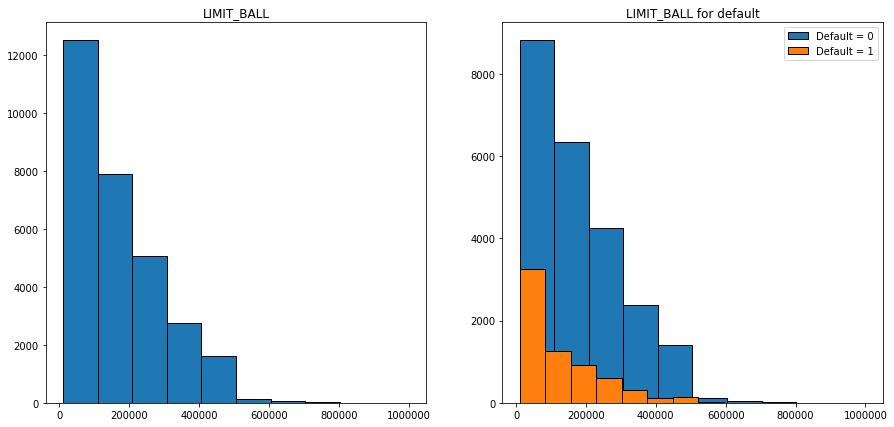

In [14]:
plt.figure(1, figsize=(15,7))
plt.subplot(121)
plt.title('LIMIT_BALL')
plt.hist(data['LIMIT_BAL'], edgecolor='k')
plt.subplot(122)
plt.title('LIMIT_BALL for default')
plt.hist(good_client['LIMIT_BAL'], edgecolor='k', label='Default = 0')
plt.hist(bad_client['LIMIT_BAL'], edgecolor='k', label='Default = 1')
plt.legend()

### 1. a) Проверка гипотезы о равенстве медианных значений кредитного лимита с помощью интервальной оценки.

H0: медианные значения не отличаются

H1: медианные значения отличаются

In [227]:
print 'For good clients median LIMIT_BAL =',  good_client['LIMIT_BAL'].median()
print 'For bad clients median LIMIT_BAL =' , bad_client['LIMIT_BAL'].median()

For good clients median LIMIT_BAL = 150000.0
For bad clients median LIMIT_BAL = 90000.0


In [19]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [25]:
np.random.seed(0)

g = np.array(map(np.median, get_bootstrap_samples(np.array(good_client['LIMIT_BAL']), 1000)))
b =np.array(map(np.median, get_bootstrap_samples(np.array(bad_client['LIMIT_BAL']), 1000)))

print 'Median difference LIMIT_BAL for good and bad clients:', stat_intervals(g-b, 0.05)

Median difference LIMIT_BAL for good and bad clients: [60000. 70000.]


 Разность медиан лежит в указанном отрезки и не включает 0, следовательно нулевую гипотизу можно отвергнуть.

### 1. б) Проверка гипотезы о равенстве распределений 

H0: распределения выборок не отличаются
    
H1: распределения выборок отличаются на величину сдвига

In [30]:
# воспользуемся функциями из примера stat.non_parametric_tests_ind

def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [31]:
print "p-value: %f" % permutation_test(good_client['LIMIT_BAL'], bad_client['LIMIT_BAL'], max_permutations = 1000)

p-value: 0.001000


Нулевая гипотеза отвергается на уровне значимости 0.05, т.е. распределения выборок отличаются на величину сдвига.


Общий вывод: люди с большей ответственностью относятся к кредитам на более крупные суммы, чем на меньшие. Хотя в РФ один банк сделал противоположный вывод, кредиты с малыми лимитами закрываются быстрее чем на большие. И таким образом повысил качество кредитного портфеля, сократив в нем кредиты с большими лимитами.

 ## 2. Проверка гипотезы о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. 

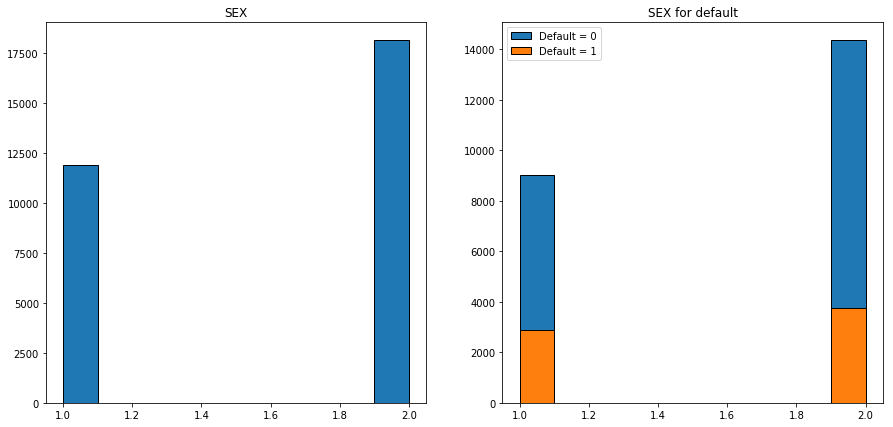

In [32]:
plt.figure(1, figsize=(15,7))
plt.subplot(121)
plt.title('SEX')
plt.hist(data['SEX'], edgecolor='k')
plt.subplot(122)
plt.title('SEX for default')
plt.hist(good_client['SEX'], edgecolor='k', label='Default = 0')
plt.hist(bad_client['SEX'], edgecolor='k', label='Default = 1')
plt.legend()

In [61]:
print 'Proportion of men in good clients:', float(good_client.loc[good_client['SEX']==1].values.shape[0])/float(good_client.shape[0])
print 'Proportion of men in bad clients:', float(bad_client.loc[bad_client['SEX']==1].values.shape[0])/float(bad_client.shape[0])

Proportion of men in good clients: 0.385850025681
Proportion of men in bad clients: 0.432941531043


In [68]:
good_men_int = proportion_confint(good_client.loc[good_client['SEX']==1].values.shape[0], good_client.shape[0])
bad_men_int = proportion_confint(bad_client.loc[bad_client['SEX']==1].values.shape[0], bad_client.shape[0])

print'Conf. int. for prop. of men in good clients: [%.4f, %.4f]' % good_men_int
print'Conf. int. for prop. of men in bad clients: [%.4f, %.4f]' % bad_men_int


Conf. int. for prop. of men (good clients): [0.3796, 0.3921]
Conf. int. for prop. of men (bad clients): [0.4210, 0.4449]


Т.к. доверительные интервалы  не пересекаются, то распределение полов по плохим и хорошим клиентам различаются.


Оценка  доверительного интервала для разности двух долей независимых выборок

In [97]:
# воспользуемся функцией из задания stat.two_proportions_diff_test
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
     
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [99]:
print "95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(np.abs(np.array(good_client['SEX'])-2), np.abs(np.array(bad_client['SEX'])-2))

95% confidence interval for a difference between proportions: [-0.060548, -0.033635]


Рассчитываем статистический Z-критерий для доли для двух независимых выборок.

H0: половой состав не отличается

H1: половой состав отличается

In [103]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [104]:
print'p-value: %.15f' % proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(np.array(good_client['SEX'])-2), np.abs(np.array(bad_client['SEX'])-2)))

p-value: 0.000000000004473


Гипотеза о равенстве выборок отвергается на уровне значимости 0.05. 

## 3. Проверка гипотезы о том, что образование не влияет на то, вернет ли клиент долг. 

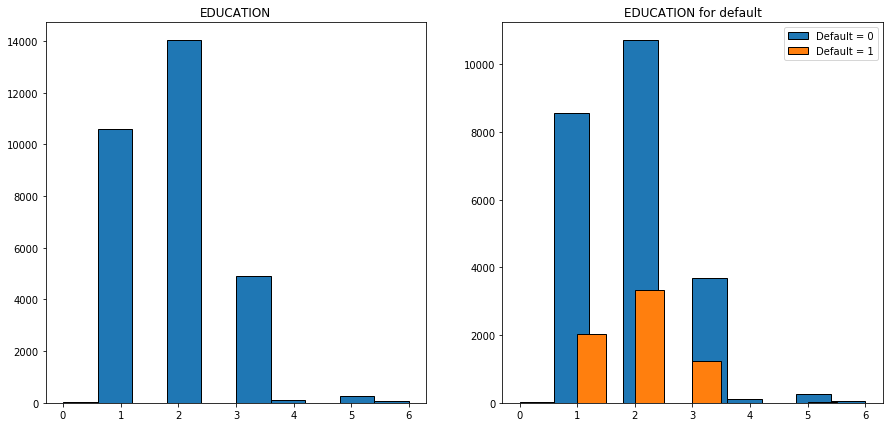

In [107]:
plt.figure(1, figsize=(15,7))
plt.subplot(121)
plt.title('EDUCATION')
plt.hist(data['EDUCATION'], edgecolor='k')
plt.subplot(122)
plt.title('EDUCATION for default')
plt.hist(good_client['EDUCATION'], edgecolor='k', label='Default = 0')
plt.hist(bad_client['EDUCATION'], edgecolor='k', label='Default = 1')
plt.legend()

H0: рассматривая величина имеет равномерное распределение

H1: рассматривая величина имеет не равномерное распределение
    
Оценка доли возврата кредитов по уровням образования. 
С помощью этой оценки строится распределение.

[0, 6, 0.5, 1]

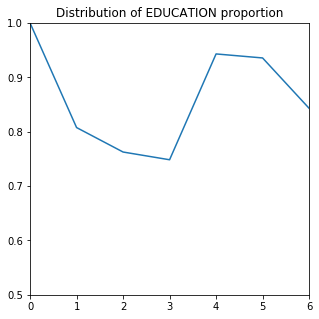

In [228]:
propoprtion_ed = np.zeros((len(np.unique(data['EDUCATION'])),2))

for i in range(propoprtion_ed.shape[0]):
    good_client_edu  = good_client.loc[good_client['EDUCATION']==i].values.shape[0]
    client_edu = data.loc[data['EDUCATION']==i].values.shape[0]
    propoprtion_ed[i, 0] = i
    propoprtion_ed[i, 1] = float(good_client_edu)/float(client_edu)
    
plt.figure(1, figsize=(5,5))
plt.title('Distribution of EDUCATION proportion')
plt.plot(propoprtion_ed[:,0], propoprtion_ed[:,1])
plt.axis([0, 6, 0.5, 1])

Распределение не является равномерным. Равномерным распределением было бы:

In [181]:
expexted_distr = propoprtion_ed[:,1].mean()
print expexted_distr

0.8629526580788338


Проверка соответствия данного распределения равномерному с помощью критерия согласия Пирсона хи-квадрат.

In [237]:
expected_f  = np.zeros(propoprtion_ed.shape[0])
good_c_edu_f = np.zeros(propoprtion_ed.shape[0])

for i in range(len(expexted_f)): 
    expected_f[i] = data.loc[data['EDUCATION']==i].values.shape[0]*expexted_distr
    good_c_edu_f[i]  = good_client.loc[good_client['EDUCATION']==i].values.shape[0]

print 'expected distr     |real distr| difference '
    
for i  in range(len(expexted_f)):
    print expected_f[i], '| ',good_c_edu_f[i], '  | ', expected_f[i]- good_c_edu_f[i]

expected distr     |real distr| difference 
12.081337213103673 |  14.0   |  -1.918662786896327
9134.353885764456 |  8549.0   |  585.3538857644562
12107.225792846039 |  10700.0   |  1407.2257928460385
4243.138219773626 |  3680.0   |  563.1382197736257
106.14317694369656 |  116.0   |  -9.85682305630344
241.62674426207346 |  262.0   |  -20.37325573792654
44.01058556202052 |  43.0   |  1.0105855620205233
p-value = 3.653181595163598e-58


Проверка соответствия данного распределения равномерному с помощью критерия согласия Пирсона хи-квадрат.

In [239]:
pvalue  = stats.chisquare(good_c_edu_f, expected_f, ddof = 1)[1]
print  'p-value =', pvalue

p-value = 3.653181595163598e-58


Нулевая гипотеза отвергается на уровне значимости 0.05, т.е. распределение качества клиентов в зависимости от образования не равномерно и может характеризовать потенциального заемщика по уровню образования: люди с докторской степенью лучше обслуживают кредиты, чем выпускники школ или бакалавры. 

## 4. Семейное положение (MARRIAGE): Проверка, как связан семейный статус с индикатором дефолта.

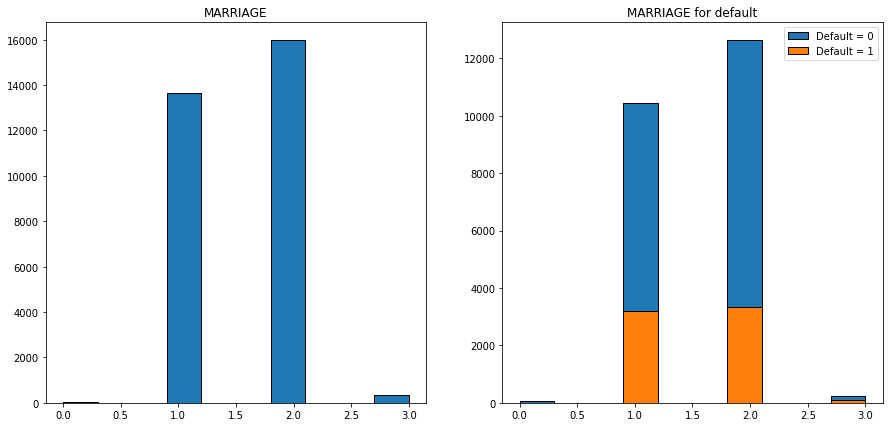

In [189]:
plt.figure(1, figsize=(15,7))
plt.subplot(121)
plt.title('MARRIAGE')
plt.hist(data['MARRIAGE'], edgecolor='k')
plt.subplot(122)
plt.title('MARRIAGE for default')
plt.hist(good_client['MARRIAGE'], edgecolor='k', label='Default = 0')
plt.hist(bad_client['MARRIAGE'], edgecolor='k', label='Default = 1')
plt.legend()

Таблица сопряжённости для признаков default и MARRIAGE и рассчет коэфициента Крамера

In [207]:
table = np.zeros((len(np.unique(data['MARRIAGE'])),2))

for i in range(conf_table.shape[0]):
    table[i, 0] = good_client.loc[good_client['MARRIAGE']==i].values.shape[0]
    table[i, 1] = bad_client.loc[bad_client['MARRIAGE']==i].values.shape[0]

hi_stat = stats.chi2_contingency(table)[0]
n = table.sum()
v_kramer = (hi_stat/(n*(min(table.shape)-1)))**0.5


print v_kramer

0.034478203662766466


Коэфициент крамера мал, поэтому можно считать что связь между семейным положением и качеством клиента отсутствует.

## 5. Возраст (Age)

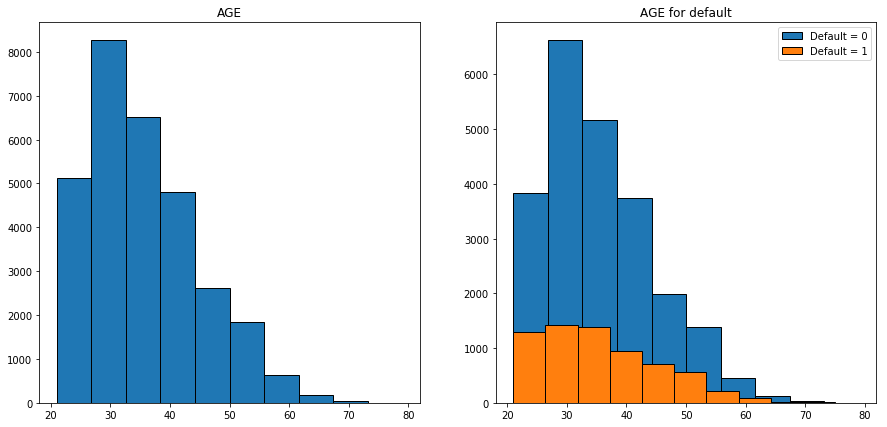

In [208]:
plt.figure(1, figsize=(15,7))
plt.subplot(121)
plt.title('AGE')
plt.hist(data['AGE'], edgecolor='k')
plt.subplot(122)
plt.title('AGE for default')
plt.hist(good_client['AGE'], edgecolor='k', label='Default = 0')
plt.hist(bad_client['AGE'], edgecolor='k', label='Default = 1')
plt.legend()

### 5. a) Проверка гипотизы о равенстве медианных значений возрастов людей

H0: медианные значения не отличаются

H1: медианные значения отличаются

In [230]:
print 'For good clients median AGE = ',  good_client['AGE'].median()
print 'For bad clients median AGE  = ',  bad_client['AGE'].median()

For good clients median AGE =  34.0
For bad clients median AGE  =  34.0


Интервальная оценка для разности медиан.

In [211]:
np.random.seed(0)

g = np.array(map(np.median, get_bootstrap_samples(np.array(good_client['AGE']), 1000)))
b =np.array(map(np.median, get_bootstrap_samples(np.array(bad_client['AGE']), 1000)))

print 'Median difference AGE for good and bad clients:', stat_intervals(g-b, 0.05)

Median difference AGE for good and bad clients: [-1.  0.]


Разность медиан лежит в указанном отрезки и включает 0, следовательно нулевую гипотизу нельзя отвергнуть.

### 5. b) Проверка гипотизы о равенстве распределений плохих и хороших клиентов

H0: распределения выборок не отличаются
    
H1: распределения выборок отличаются на величину сдвига

In [213]:
print "p-value: %f" % permutation_test(good_client['AGE'], bad_client['AGE'], max_permutations = 1000)

p-value: 0.017000


Нулевая гипотеза отвергается на уровне значимости 0.05, т.е. возраст потенциальго заемщика характеризует качество обслуживания кредита